In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import subprocess
import pickle
import numpy as np
import time
import seaborn as sns
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d, gaussian_filter

In [2]:
df_comb = []
exps = ["qqp_subsamp_low_lr_high", "qqp_subsamp_low_lr_high2", "qqp_subsamp_low_lr_low", "qqp_subsamp_low_lr_low2"]
for exp in exps:
    fname = f"{exp}_max_neg_train_loss.pkl"
    df_seed = pd.read_pickle(fname)
    df_comb.append(df_seed)
    
df = pd.concat(df_comb)
df['train/loss'] = -df['train/loss']

In [3]:
df

,train/loss,lr,subsamp_ratio,sample_prob,seed
61,0.3839,0.0004,0.1,1.0,1.0
67,0.3492,0.0004,0.1,1.0,2.0
66,0.3346,0.0004,0.1,1.0,5.0
61,0.3687,0.0004,0.1,1.0,3.0
63,0.3307,0.0004,0.1,1.0,4.0
...,...,...,...,...,...
62,0.1331,0.0004,0.9,1.0,6.0
67,0.1562,0.0004,0.9,1.0,7.0
67,0.1448,0.0004,0.9,1.0,8.0
63,0.1387,0.0004,0.9,1.0,9.0


In [4]:
df_avg = df.groupby(['subsamp_ratio', 'sample_prob', 'lr']).mean()
df_std = df.groupby(['subsamp_ratio', 'sample_prob', 'lr']).std()
# lrs = df_avg.index.get_level_values('lr').unique()
subsamp_ratios = sorted(df_avg.index.get_level_values('subsamp_ratio').unique())[::-1]
sample_probs = sorted(df_avg.index.get_level_values('sample_prob').unique())
best_lrs = np.zeros((len(subsamp_ratios), len(sample_probs)))
best_lrs_smooth = np.zeros((len(subsamp_ratios), len(sample_probs)))
best_lrs_spline = np.zeros((len(subsamp_ratios), len(sample_probs)))


count = 0
for subsamp_ratio_idx in range(len(subsamp_ratios)):
    for sample_prob_idx in range(len(sample_probs)):
        count += 1
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
#         if 15 < count < 20:
#             plt.figure()
#             print(idx_tup)
#             plt.plot(np.log(lrs), df_from_tup["eval/accuracy"])
        
        lr_max = df_from_tup["train/loss"].idxmin()
        lrs = df_from_tup.index.values
        sigma = 1
        smoothed_vals = gaussian_filter1d(df_from_tup["train/loss"], sigma)
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["train/loss"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        lr_max_spline = np.exp(xs[np.argmin(spl(xs))])
        lr_max_smooth = lrs[np.argmin(smoothed_vals)]
        acc_max = df_from_tup.loc[lr_max, "train/loss"]
        best_lrs[subsamp_ratio_idx, sample_prob_idx] = lr_max
        best_lrs_smooth[subsamp_ratio_idx, sample_prob_idx] = lr_max_smooth
        best_lrs_spline[subsamp_ratio_idx, sample_prob_idx] = lr_max_spline

        


In [5]:
all_lrs = sorted(df_avg.index.get_level_values('lr').unique())
print(np.log(all_lrs))
print(all_lrs)

[-11.51292546 -11.32230511 -11.12766306 -10.93070985 -10.7381983
 -10.54214655 -10.34665453 -10.15451631  -9.95900026  -9.76546625
  -9.57131024  -9.37757629  -9.18078157  -8.98719682  -8.79163004
  -8.6005748   -8.40833879  -8.21339174  -8.01945281  -7.82404601
  -7.70626298  -7.56168175  -7.4020516   -7.27881896  -7.19543735
  -7.09408486  -7.01311579]
[1e-05, 1.21e-05, 1.47e-05, 1.79e-05, 2.17e-05, 2.64e-05, 3.21e-05, 3.89e-05, 4.73e-05, 5.74e-05, 6.97e-05, 8.46e-05, 0.000103, 0.000125, 0.000152, 0.000184, 0.000223, 0.000271, 0.000329, 0.0004, 0.00045, 0.00052, 0.00061, 0.00069, 0.00075, 0.00083, 0.0009]


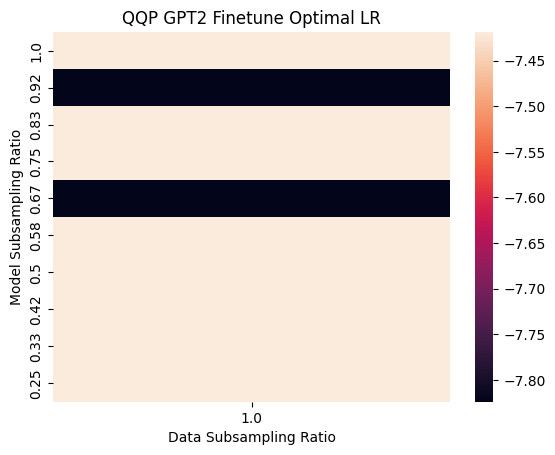

In [6]:
best_lrs_log = gaussian_filter(np.log(best_lrs_smooth), 0.0)
s = sns.heatmap(best_lrs_log, xticklabels=sample_probs, yticklabels=subsamp_ratios, vmin=np.min(best_lrs_log), vmax=np.max(best_lrs_log))
s.set_xlabel("Data Subsampling Ratio")
s.set_ylabel("Model Subsampling Ratio")
s.set_title("QQP GPT2 Finetune Optimal LR")
fig = s.get_figure()

# fig.savefig("mnli_gpt2_opt_lr.png")
plt.show()


In [10]:
x_grid = subsamp_ratios
y_grid = sample_probs
X, Y = np.meshgrid(x_grid, y_grid)
all_obs = np.vstack((X.ravel(), Y.ravel())).T
vals = best_lrs_log.ravel(order='F')

In [11]:
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator, LinearNDInterpolator
mse = 0
num_trials = 1000
for trial in range(num_trials):
    num_obs = 100
    train_idx = np.sort(np.random.choice(len(all_obs), size=num_obs, replace=False))
    test_idx = np.sort(np.array([i for i in range(len(all_obs)) if i not in train_idx]))
    interp = RBFInterpolator(all_obs[train_idx], vals[train_idx], kernel="cubic", smoothing=0.1)
    # interp = NearestNDInterpolator(all_obs[train_idx], vals[train_idx])
    preds = interp(all_obs)
    mse += np.mean(np.square(preds - vals))
mse = mse / num_trials
print(mse)

3.155443620884047e-29


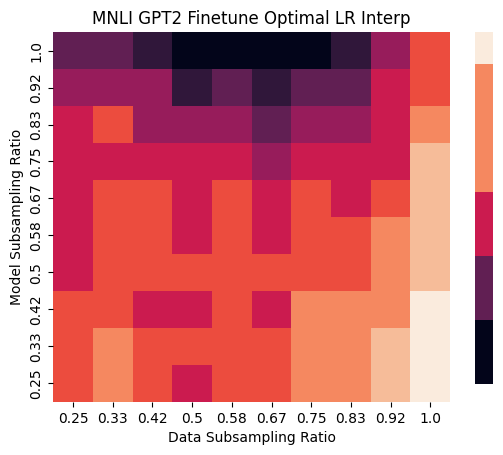

In [12]:
preds_grid = np.reshape(preds, (len(x_grid), len(y_grid)), order='F')
s = sns.heatmap(preds_grid, xticklabels=sample_probs, yticklabels=subsamp_ratios, vmin=np.min(preds_grid), vmax=np.max(preds_grid))
s.set_xlabel("Data Subsampling Ratio")
s.set_ylabel("Model Subsampling Ratio")
s.set_title("MNLI GPT2 Finetune Optimal LR Interp")
fig = s.get_figure()
# fig.savefig("mnli_gpt2_opt_lr.png")
plt.show()

[-7.82404601 -7.70626298 -7.56168175 -7.4020516  -7.27881896 -7.19543735
 -7.09408486]
[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]


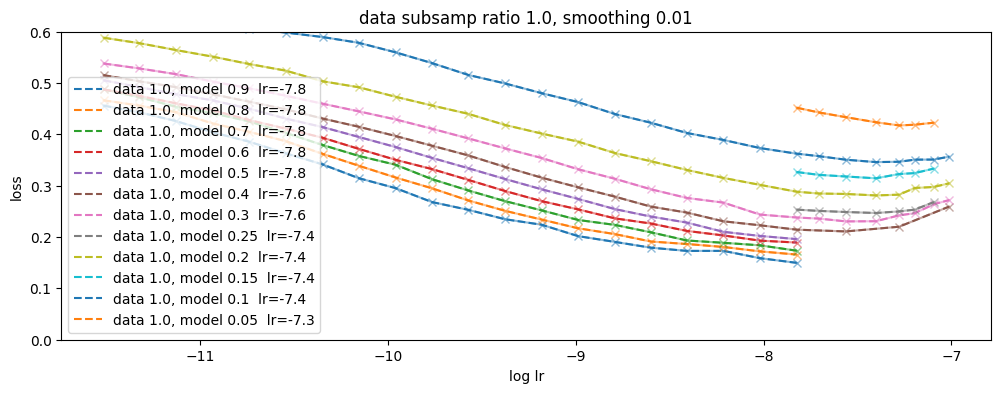

In [8]:
# df_avg
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 4))
count = 0
sample_prob_idx = 0
sigma = 0.01
for subsamp_ratio_idx in range(len(subsamp_ratios)):
    if subsamp_ratio_idx % 1 == 0:
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
        lr_max = df_from_tup["train/loss"].idxmin()
        lrs = df_from_tup.index.values
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["train/loss"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        smoothed_vals = gaussian_filter1d(df_from_tup["train/loss"], sigma)
        lr_max_smooth = log_lrs[np.argmin(smoothed_vals)]
        lr_max_spline = xs[np.argmin(spl(xs))]
        
        line = ax1.plot(np.log(lrs), df_from_tup["train/loss"], alpha=0.5, marker="x")
        line_color = line[0].get_color()
        ax1.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, model {idx_tup[0]}  lr={np.round(lr_max_smooth, 1)}")
        # plt.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, lr={np.round(lr_max_smooth, 1)}, spline={np.round(lr_max_spline, 1)}")
        # plt.plot(xs, spl(xs), color=line_color, linestyle='dashdot')
        # ax1.axvline(x=np.log(1.38e-03), color='grey', linestyle=':')
        count += 3
ax1.legend()
ax1.set_title(f"data subsamp ratio {idx_tup[1]}, smoothing {sigma}")
ax1.set_xlabel('log lr')
ax1.set_ylabel('loss')
ax1.set_ylim([0, 0.6])
print(log_lrs)
print(subsamp_ratios)
plt.show()

In [29]:
df_avg.loc[(0.25, 1.0), :]

,train/loss,seed
lr,,
0.000010,0.557717,3.5
0.000015,0.531200,3.5
0.000023,0.504033,3.5
0.000034,0.471417,3.5
0.000051,0.436833,3.5
0.000078,0.398983,3.5
0.000117,0.358733,3.5
0.000176,0.317300,3.5
0.000265,0.278183,3.5


In [30]:
df_std.loc[(0.25, 1.0), :]

,train/loss,seed
lr,,
0.000010,0.027099,1.870829
0.000015,0.022270,1.870829
0.000023,0.015237,1.870829
0.000034,0.010677,1.870829
0.000051,0.012715,1.870829
0.000078,0.010344,1.870829
0.000117,0.010434,1.870829
0.000176,0.007501,1.870829
0.000265,0.015074,1.870829


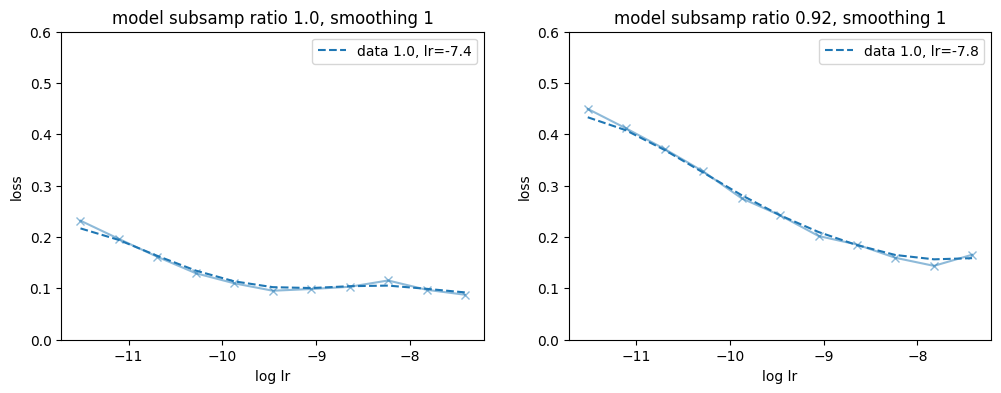

In [7]:
# df_avg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
count = 0
subsamp_ratio_idx = 0
for sample_prob_idx in range(len(sample_probs)):
    if sample_prob_idx % 2 == 0:
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
        lr_max = df_from_tup["train/loss"].idxmin()
        lrs = df_from_tup.index.values
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["train/loss"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        sigma = 1
        smoothed_vals = gaussian_filter1d(df_from_tup["train/loss"], sigma)
        lr_max_smooth = log_lrs[np.argmin(smoothed_vals)]
        lr_max_spline = xs[np.argmin(spl(xs))]
        
        line = ax1.plot(np.log(lrs), df_from_tup["train/loss"], alpha=0.5, marker="x")
        line_color = line[0].get_color()
        ax1.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, lr={np.round(lr_max_smooth, 1)}")
        # plt.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, lr={np.round(lr_max_smooth, 1)}, spline={np.round(lr_max_spline, 1)}")
        # plt.plot(xs, spl(xs), color=line_color, linestyle='dashdot')
        # ax1.axvline(x=np.log(1.38e-03), color='grey', linestyle=':')
        count += 3
ax1.legend()
ax1.set_title(f"model subsamp ratio {idx_tup[0]}, smoothing {sigma}")
ax1.set_xlabel('log lr')
ax1.set_ylabel('loss')
ax1.set_ylim([0, 0.6])

count = 0
subsamp_ratio_idx = 1
for sample_prob_idx in range(len(sample_probs)):
    if sample_prob_idx % 2 == 0:
        idx_tup = (subsamp_ratios[subsamp_ratio_idx], sample_probs[sample_prob_idx])
        df_from_tup = df_avg.loc[idx_tup, :]
        lr_max = df_from_tup["train/loss"].idxmin()
        lrs = df_from_tup.index.values
        log_lrs = np.log(lrs)
        spl = UnivariateSpline(log_lrs, df_from_tup["train/loss"])
        xs = np.linspace(np.min(log_lrs), np.max(log_lrs))
        sigma = 1
        smoothed_vals = gaussian_filter1d(df_from_tup["train/loss"], sigma)
        lr_max_smooth = log_lrs[np.argmin(smoothed_vals)]
        lr_max_spline = xs[np.argmin(spl(xs))]
        
        line = ax2.plot(np.log(lrs), df_from_tup["train/loss"], alpha=0.5, marker="x")
        line_color = line[0].get_color()
        ax2.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, lr={np.round(lr_max_smooth, 1)}")
        # plt.plot(np.log(lrs), smoothed_vals, color=line_color, linestyle='--', label=f"data {idx_tup[1]}, lr={np.round(lr_max_smooth, 1)}, spline={np.round(lr_max_spline, 1)}")
        # plt.plot(xs, spl(xs), color=line_color, linestyle='dashdot')
        # ax2.axvline(x=np.log(1.38e-03), color='grey', linestyle=':')
        count += 3
ax2.legend()
ax2.set_title(f"model subsamp ratio {idx_tup[0]}, smoothing {sigma}")
ax2.set_xlabel('log lr')
ax2.set_ylabel('loss')
ax2.set_ylim([0, 0.6])

plt.show()

In [28]:
df_avg.loc[(slice(None), slice(None), 1.38e-03), :]

train/loss  seed
subsamp_ratio sample_prob lr                       
0.46          0.25        0.00138    0.138925   2.5
              0.29        0.00138    0.260125   2.5
              0.34        0.00138    0.270600   2.5
              0.40        0.00138    0.363650   2.5
              0.46        0.00138    0.485650   2.5
              0.54        0.00138    0.518550   2.5
              0.63        0.00138    0.576575   2.5
              0.73        0.00138    0.593050   2.5
              0.86        0.00138    0.389225   2.5
              1.00        0.00138    0.639950   2.5
0.54          0.25        0.00138    0.302500   2.5
              0.29        0.00138    0.288525   2.5
              0.34        0.00138    0.382825   2.5
              0.40        0.00138    0.472650   2.5
              0.46        0.00138    0.742625   2.5
              0.54        0.00138    0.579025   2.5
              0.63        0.00138    0.557125   2.5
              0.73        0.00138    0.594350   2.5
              0.86        0.00138    0.831575   2.5
              1.00        0.00138    0.653350   2.5
0.63          0.25        0.00138    0.322075   2.5
              0.29        0.00138    0.554000   2.5
              0.34        0.00138    0.436325   2.5
              0.40        0.00138    0.719975   2.5
              0.46        0.00138    0.697475   2.5
              0.54        0.00138    0.570375   2.5
              0.63        0.00138    0.585725   2.5
              0.73        0.00138    0.833325   2.5
              0.86        0.00138    0.629300   2.5
              1.00        0.00138    0.867250   2.5
0.73          0.25        0.00138    0.269700   2.5
              0.29        0.00138    0.324200   2.5
              0.34        0.00138    0.482200   2.5
              0.40        0.00138    0.511375   2.5
              0.46        0.00138    0.523075   2.5
              0.54        0.00138    0.581525   2.5
              0.63        0.00138    0.590525   2.5
              0.73        0.00138    0.627600   2.5
              0.86        0.00138    0.645400   2.5
              1.00        0.00138    0.648225   2.5
0.86          0.25        0.00138    0.397750   2.5
              0.29        0.00138    0.397200   2.5
              0.34        0.00138    0.646150   2.5
              0.40        0.00138    0.491425   2.5
              0.46        0.00138    0.589275   2.5
              0.54        0.00138    0.573275   2.5
              0.63        0.00138    0.601475   2.5
              0.73        0.00138    0.858975   2.5
              0.86        0.00138    0.864125   2.5
              1.00        0.00138    0.668875   2.5

In [15]:
df_avg.loc[(slice(None), slice(None), 9.11e-04), :]

train/loss  seed
subsamp_ratio sample_prob lr                        
0.46          0.25        0.000911    0.045850   6.5
              0.29        0.000911    0.116250   6.5
              0.34        0.000911    0.105300   6.5
              0.40        0.000911    0.158750   6.5
              0.46        0.000911    0.227050   6.5
              0.54        0.000911    0.289775   6.5
              0.63        0.000911    0.360525   6.5
              0.73        0.000911    0.396400   6.5
              0.86        0.000911    0.481100   6.5
              1.00        0.000911    0.569950   6.5
0.54          0.25        0.000911    0.044525   6.5
              0.29        0.000911    0.064325   6.5
              0.34        0.000911    0.101050   6.5
              0.40        0.000911    0.156525   6.5
              0.46        0.000911    0.200850   6.5
              0.54        0.000911    0.280575   6.5
              0.63        0.000911    0.360100   6.5
              0.73        0.000911    0.425325   6.5
              0.86        0.000911    0.478950   6.5
              1.00        0.000911    0.581350   6.5
0.63          0.25        0.000911    0.033250   6.5
              0.29        0.000911    0.052900   6.5
              0.34        0.000911    0.081800   6.5
              0.40        0.000911    0.120400   6.5
              0.46        0.000911    0.201775   6.5
              0.54        0.000911    0.265325   6.5
              0.63        0.000911    0.370125   6.5
              0.73        0.000911    0.364850   6.5
              0.86        0.000911    0.460950   6.5
              1.00        0.000911    0.584350   6.5
0.73          0.25        0.000911    0.027800   6.5
              0.29        0.000911    0.042950   6.5
              0.34        0.000911    0.077250   6.5
              0.40        0.000911    0.139250   6.5
              0.46        0.000911    0.198925   6.5
              0.54        0.000911    0.265875   6.5
              0.63        0.000911    0.339375   6.5
              0.73        0.000911    0.387325   6.5
              0.86        0.000911    0.480125   6.5
              1.00        0.000911    0.588525   6.5
0.86          0.25        0.000911    0.035200   6.5
              0.29        0.000911    0.053400   6.5
              0.34        0.000911    0.111650   6.5
              0.40        0.000911    0.129250   6.5
              0.46        0.000911    0.165925   6.5
              0.54        0.000911    0.283650   6.5
              0.63        0.000911    0.383775   6.5
              0.73        0.000911    0.296325   6.5
              0.86        0.000911    0.401550   6.5
              1.00        0.000911    0.614100   6.5

In [16]:
df_avg.loc[(slice(None), slice(None), 2.08e-03), :]

train/loss  seed
subsamp_ratio sample_prob lr                       
0.46          0.25        0.00208    0.567975   6.5
              0.29        0.00208    0.399375   6.5
              0.34        0.00208    0.194575   6.5
              0.40        0.00208    0.225625   6.5
              0.46        0.00208    0.225000   6.5
              0.54        0.00208    0.467750   6.5
              0.63        0.00208    0.229775   6.5
              0.73        0.00208    0.000000   6.5
              0.86        0.00208    0.000000   6.5
              1.00        0.00208    0.489825   6.5
0.54          0.25        0.00208    0.000000   6.5
              0.29        0.00208    0.207025   6.5
              0.34        0.00208    0.224575   6.5
              0.40        0.00208    0.215300   6.5
              0.46        0.00208    0.000000   6.5
              0.54        0.00208    0.233900   6.5
              0.63        0.00208    0.235450   6.5
              0.73        0.00208    0.000000   6.5
              0.86        0.00208    0.241975   6.5
              1.00        0.00208    0.000000   6.5
0.63          0.25        0.00208    0.162175   6.5
              0.29        0.00208    0.203525   6.5
              0.34        0.00208    0.000000   6.5
              0.40        0.00208    0.000000   6.5
              0.46        0.00208    0.000000   6.5
              0.54        0.00208    0.000000   6.5
              0.63        0.00208    0.246800   6.5
              0.73        0.00208    0.000000   6.5
              0.86        0.00208    0.000000   6.5
              1.00        0.00208    0.000000   6.5
0.73          0.25        0.00208    0.000000   6.5
              0.29        0.00208    0.000000   6.5
              0.34        0.00208    0.000000   6.5
              0.40        0.00208    0.000000   6.5
              0.46        0.00208    0.000000   6.5
              0.54        0.00208    0.000000   6.5
              0.63        0.00208    0.000000   6.5
              0.73        0.00208    0.000000   6.5
              0.86        0.00208    0.000000   6.5
              1.00        0.00208    0.000000   6.5
0.86          0.25        0.00208    0.000000   6.5
              0.29        0.00208    0.000000   6.5
              0.34        0.00208    0.000000   6.5
              0.40        0.00208    0.000000   6.5
              0.46        0.00208    0.000000   6.5
              0.54        0.00208    0.000000   6.5
              0.63        0.00208    0.000000   6.5
              0.73        0.00208    0.506950   6.5
              0.86        0.00208    0.000000   6.5
              1.00        0.00208    0.000000   6.5

In [15]:
print(np.log(lrs))
print(lrs)

[-11.51292546 -11.10746036 -10.69314563 -10.28328491  -9.87392875
  -9.46394313  -9.05333662  -8.64502656  -8.23578073  -7.82404601
  -7.41193636  -7.00096766  -6.58567178  -6.17538739  -5.76672227]
[1.00e-05 1.50e-05 2.27e-05 3.42e-05 5.15e-05 7.76e-05 1.17e-04 1.76e-04
 2.65e-04 4.00e-04 6.04e-04 9.11e-04 1.38e-03 2.08e-03 3.13e-03]


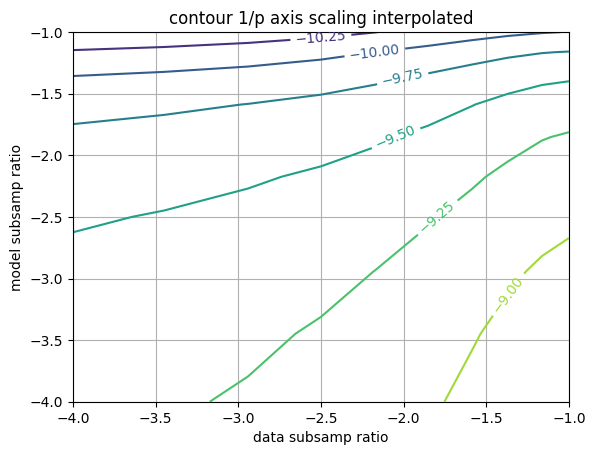

In [151]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
subsamp_ratios_rescale = -1 / subsamp_ratios_rescale

sample_probs_rescale = np.array(sample_probs)
sample_probs_rescale = -1 / sample_probs_rescale
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, preds_grid)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour 1/p axis scaling interpolated')
plt.grid()
plt.show()

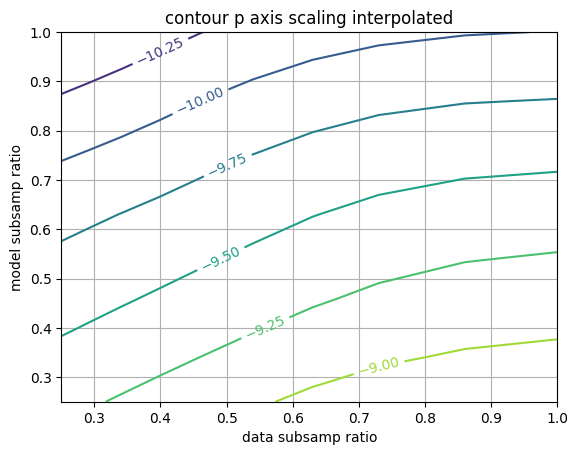

In [152]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
# subsamp_ratios_rescale = -1 / subsamp_ratios_rescale

sample_probs_rescale = np.array(sample_probs)
# sample_probs_rescale = -1 / sample_probs_rescale
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, preds_grid)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour p axis scaling interpolated')
plt.grid()
plt.show()

In [158]:
X = np.hstack((all_obs, np.ones((100, 1))))
X[:, [0, 1]] = X[:, [1, 0]]
beta = np.dot(np.linalg.pinv(X), preds)
print(beta)
print(np.dot(beta, np.array([0.3, 0.9, 1])))
print(-beta[0] / beta[1], -(9.5 + beta[2]) / beta[1])

[ 0.68877364 -1.50840502 -9.05393836]
-10.204870790351249
0.45662380504952815 0.29571741660732176


[0.6221703  0.84130852]
[0.58347621 0.72849996]
[0.62071681 0.57904204]
[0.66249827 0.40257544]
[0.69628637 0.20630629]
[0.65172738 0.04362417]
[ 0.480828  -0.0280954]


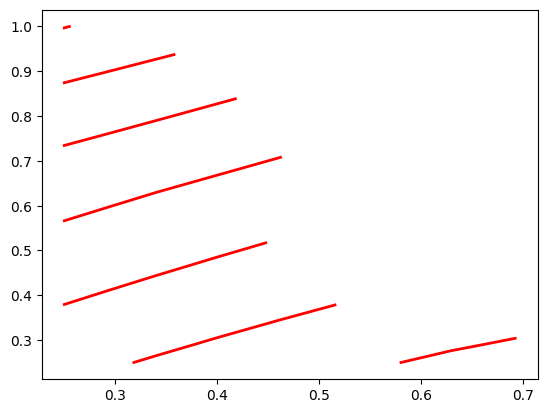

In [142]:
# Extract contour lines
contour_lines = CS.collections

# Access and manipulate contour lines
for contour_line in contour_lines:
    if len(contour_line.get_paths()) > 0:
        # Extract x and y coordinates of contour line
        contour_line_x = contour_line.get_paths()[0].vertices[:, 0]
        contour_line_y = contour_line.get_paths()[0].vertices[:, 1]

        regression_coefficients = np.polyfit(contour_line_x, contour_line_y, deg=1)
        print(regression_coefficients)
        regression_line_y = np.polyval(regression_coefficients, np.linspace(-4, -1))

        # Plot the contour line and the regression line
        plt.plot(contour_line_x, contour_line_y, 'r', linewidth=2)
        # plt.plot(np.linspace(-4, -1), regression_line_y, 'b', linewidth=2)

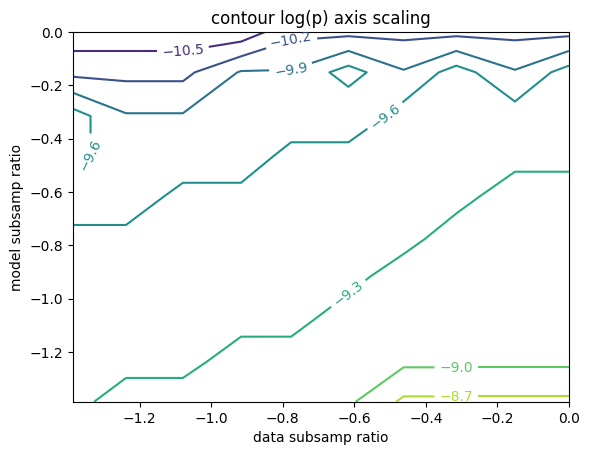

In [143]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
subsamp_ratios_rescale = np.log(subsamp_ratios_rescale)
sample_probs_rescale = np.array(sample_probs)
sample_probs_rescale = np.log(sample_probs_rescale)
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, best_lrs_log)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour log(p) axis scaling')
plt.show()

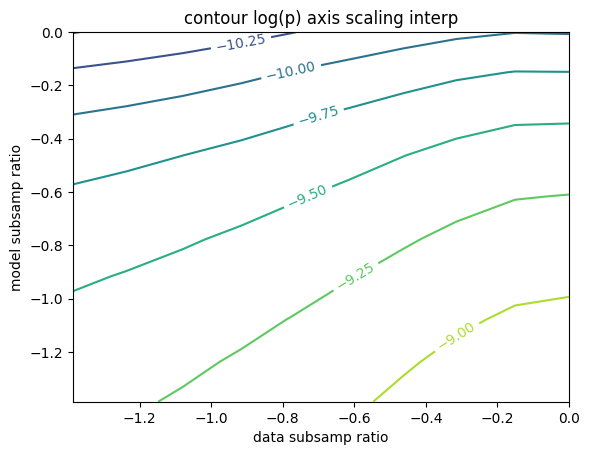

In [144]:
subsamp_ratios_rescale = np.array(subsamp_ratios)
subsamp_ratios_rescale = np.log(subsamp_ratios_rescale)
sample_probs_rescale = np.array(sample_probs)
sample_probs_rescale = np.log(sample_probs_rescale)
xv, yv = np.meshgrid(sample_probs_rescale, subsamp_ratios_rescale)
CS = plt.contour(xv, yv, preds_grid)
plt.clabel(CS, inline=True, fontsize=10)
# plt.contourf(xv, yv, best_lrs_log)
# plt.scatter(xv, yv, c=best_lrs_log.flatten())
plt.xlabel('data subsamp ratio')
plt.ylabel('model subsamp ratio')
plt.title('contour log(p) axis scaling interp')
plt.show()

In [97]:
best_lrs

array([[2.e-04, 2.e-04, 2.e-04, 2.e-04, 2.e-04],
       [1.e-04, 1.e-04, 2.e-04, 2.e-04, 2.e-04],
       [1.e-04, 1.e-04, 1.e-04, 1.e-04, 2.e-04],
       [5.e-05, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05]])

In [99]:
np.log(lrs)

Float64Index([-10.596634733096073,  -9.903487552536127,  -9.210340371976182,
               -8.517193191416238,  -7.824046010856292],
             dtype='float64', name='lr')

In [43]:
from scipy.stats import levy_stable
alpha, beta = 1.8, -0.5
mean, var, skew, kurt = levy_stable.stats(alpha, beta, moments='mvsk')

In [59]:
n = 1000
m = 500
r = levy_stable.rvs(alpha, beta, size=n)

In [81]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

0.4755515694434887


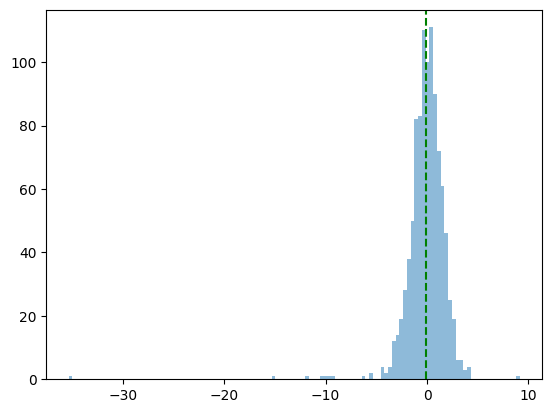

In [83]:
plt.hist(r, bins="auto", alpha=0.5)
mean_n = np.mean(r)
plt.axvline(mean_n, color="green", linestyle="dashed")
print(sigmoid(mean_n))
plt.show()

In [84]:
draws = np.zeros(10)
for draw in range(len(draws)):
    idx = np.random.choice(n, m, replace=False)
    r_hat = r[idx]
    mean_m = sigmoid(np.mean(r_hat))
    draws[draw] = mean_m
    

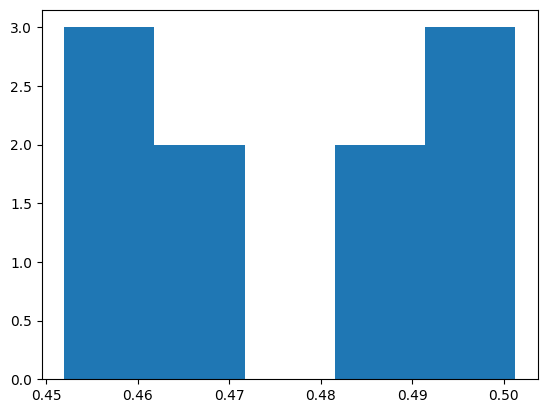

In [85]:
plt.hist(draws, bins="auto")
plt.show()

In [86]:
np.mean(draws)

0.47657247735921826